In [1]:
from IPython.display import Image

In [2]:
!python sklearn_alone.py

gp - sklearn ( 1 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1)) 
kernel: 0.00316**2 * RBF(length_scale=109) + WhiteKernel(noise_level=0.637)
theta: [-11.51292546   4.69457218  -0.45065571] [1.00000000e-05 1.09352016e+02 6.37210191e-01]
likelihood: -23.87233736198489
gp - sklearn ( 2 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89336431 -1.00663819 -1.22409422] [0.4092765  0.36544547 0.2940239 ]
likelihood: -21.80509089016203
0.00316**2 * RBF(length_scale=109) + WhiteKernel(noise_level=0.637)
0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)


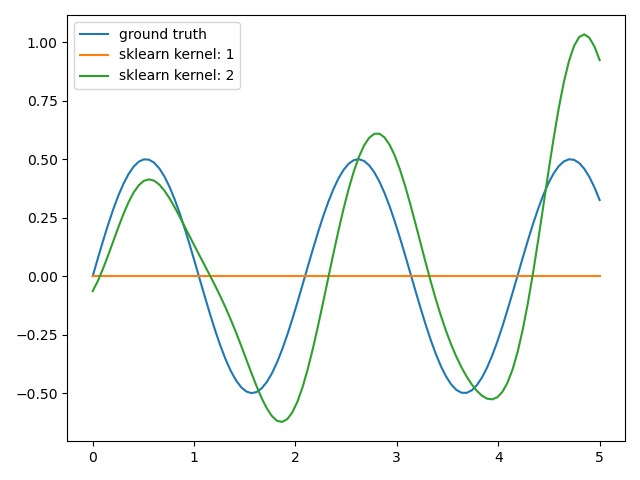

In [3]:
Image(filename='plots/sklearn_kernel.png') 

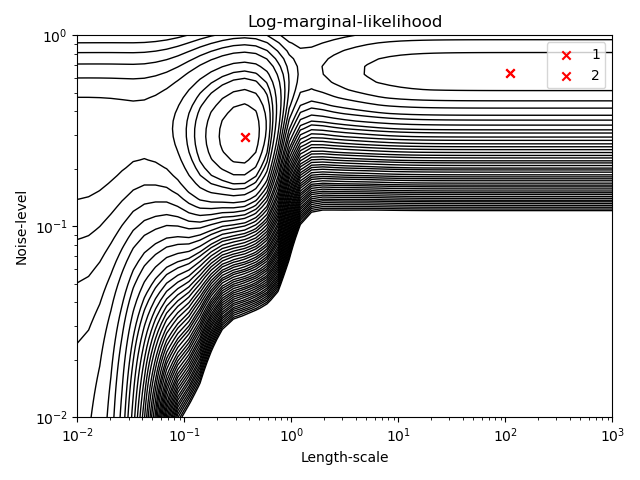

In [4]:
Image(filename='plots/sklearn_lml.png') 

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
LML = np.load('data/lml_arr.npy')

In [8]:
!time python sklearn_with_hgdl.py

HGDL -----------------------------------------------------------
[[0.40927963 0.36544607 0.29402401]
 [0.27376753 0.01029207 0.36340193]
 [0.26934014 0.0103384  0.36782916]
 [0.2295173  0.01082952 0.40765315]
 [0.15863175 0.01229567 0.47853767]]
gp - HGDL ( 1 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89335668 -1.00663656 -1.22409386] [0.40927963 0.36544607 0.29402401]
likelihood: -21.805090890122035
gp - HGDL ( 2 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=0.523**2 * RBF(length_scale=0.0103) + WhiteKernel(noise_level=0.363)) 
kernel: 0.523**2 * RBF(length_scale=0.0103) + WhiteKernel(noise_level=0.363)
theta: [-1.29547598 -4.57638168 -1.01224581] [0.27376753 0.01029207 0.36340193]
likelihood: -23.86915828705175
gp - HGDL ( 3 ):  GaussianProcessRegressor(alpha=0.0,
             

In [9]:
thetas = np.exp(np.load('data/hgdl_thetas.npy'))

In [10]:
thetas

array([[0.40927963, 0.36544607, 0.29402401],
       [0.27376753, 0.01029207, 0.36340193],
       [0.26934014, 0.0103384 , 0.36782916],
       [0.2295173 , 0.01082952, 0.40765315],
       [0.15863175, 0.01229567, 0.47853767]])

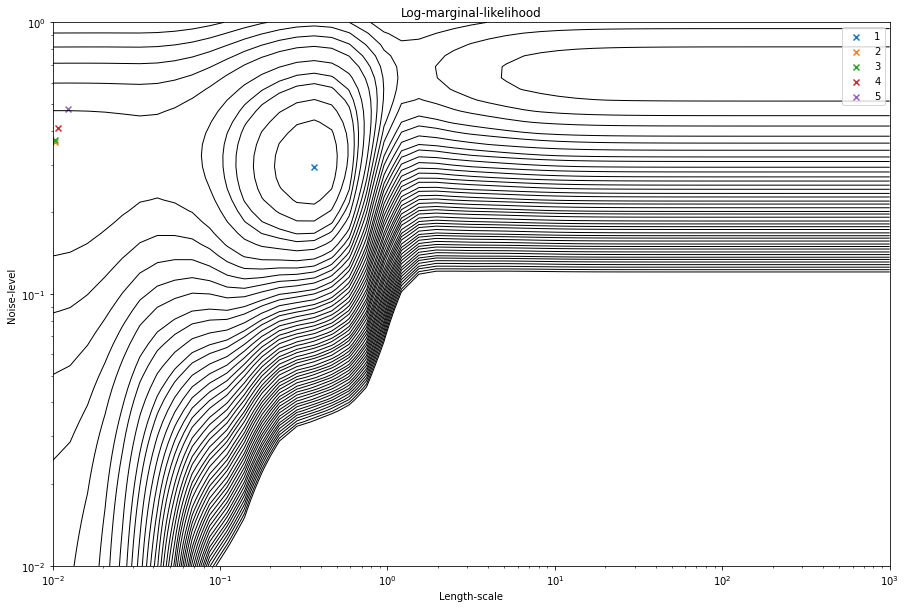

In [12]:
plt.figure(figsize=(15,10))

theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
from matplotlib.colors import LogNorm

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            #levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
            levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood");
x, y = thetas[:,1], thetas[:,2]
for i, (pt_x, pt_y) in enumerate(zip(x,y)):
    name = str(i+1)
    plt.scatter(pt_x, pt_y, marker='x', label=name)
#    plt.scatter(x, y, c='red', marker='x', label=name)

    #print(x,y)
plt.legend();
plt.savefig('plots/hgdl_lml')